 Simulation with the prediction block having a perfect knowledge of the future i.e.

#### $\hspace{15px}$ $\tilde{X}(k) = X(k)$, 
#### $\hspace{15px}$ $\tilde{Y}(k) = Y(k)$, 




---

#### Import Modules 


In [1]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.timeseries.output_writer import OutputWriter
from pandapower.plotting import simple_plot,simple_plotly,pf_res_plotly
import ipyparallel as ipp
import math as mt
import pandapower.plotting as pt
from pandapower.plotting.plotly import simple_plotly
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [2]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

#### Import Networks


In [3]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


#### Import and dataClead files for component of the network

In [4]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = oriFc.readAndReshape_input(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = oriFc.readAndReshape_input(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = oriFc.readAndReshape_input(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = oriFc.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = oriFc.readAndReshape_input(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])
# Data cleaning on Consumption
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('07:00','18:50')
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index>='2021 06 01']
per_index = df_final.index


#### Data extraction on the network

In [5]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

# redefine data given final dataframe
df_prodHT = df_final[['P0013','P0018','P0100']] 
df_prod_bt_total = df_final[['Prod_BT']]
df_cons_total = df_final[['Cons']]

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Create daylight period mask 

In [6]:
# daylight_mask = (df_prodHT.P0013>0)|(df_prodHT.P0018>0)|(df_prodHT.P0100>0)|(df_prod_bt_total.Prod_BT>0)

#### Start Parallel engines

In [7]:
n_engines = 7  # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

### No Control 

#### Send data into local space of each engine

In [8]:
# Import following modules on the local space of clients or engines
with rc[:].sync_imports(): 
    import numpy, pandapower, pandas, tqdm, par_oriFunctions
    
# Share the total number of simulation period among all the engines
dview.scatter('period',per_index)


# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = False 
parameters_dict = dict({'net_civaux':net_civaux, 
                 'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                 'sum_max_main_network':sum_max_main_network, 
                 'dict_df_sgenLoad':dict_df_sgenLoad,  
                 'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client engine(s)

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing tqdm on engine(s)
importing Par_myFunctions on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine

In [9]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, 
                                          sum_max_main_network, dict_df_sgenLoad, opf_status) for cur_period in period]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [10]:
# Gather the result of each engine in a sigle list
list_max_vm_pu = dview.gather('resulting')

#### Plot the maximum voltage on the network 

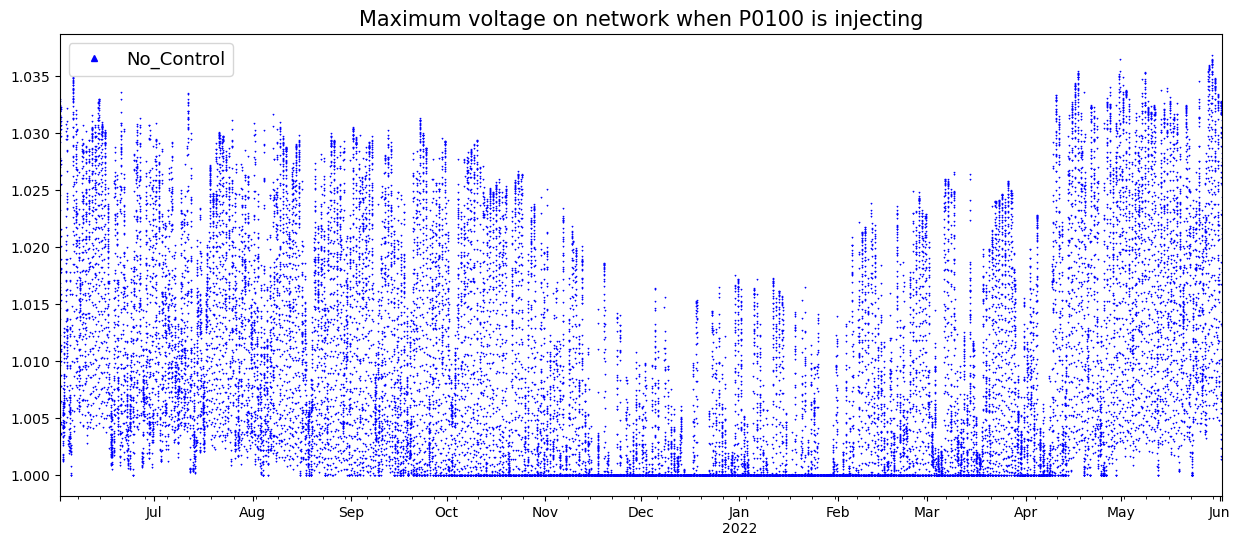

In [11]:
max_vm_pu_df = pd.DataFrame(data=list_max_vm_pu, index=per_index, columns=['No_Control'])
fig, axx = plt.subplots(figsize=(15,6))
max_vm_pu_df.plot(ax=axx, style='b^',markersize=0.5,)

plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network when P0100 is injecting", fontsize=15);
# plt.xlim(['2020 01 01', '2020 01 03'])

## OPF: Future known

#### Reload network

In [12]:
net_civaux2=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Add a controllable line to the static generators
net_civaux2.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux2.sgen['controllable'][net_civaux2.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux2.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux2.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux2.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux2_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(net_civaux2) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux2.res_bus.vm_pu[net_civaux2.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux2_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux2_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [13]:
vm_mu_max, vm_mu_min = 1.02250, 0.95  # Choosen 

# net_civaux2.bus.max_vm_pu[net_civaux2.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux2.bus.max_vm_pu[net_civaux2_hv_activated_bus] = vm_mu_max
net_civaux2.bus.min_vm_pu[net_civaux2_hv_activated_bus] = vm_mu_min


In [14]:
# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux2,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux2.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux2.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Send data into local space of each engine

In [15]:
vm_mu_max

1.0225

In [16]:
# Shuffle period index so that the parallel engines can take different part and work on in 
# otherwise the basic scatter divides in the number of engines and send it. Hence some engine 
# will get part of the data where no need to do opf
from sklearn.model_selection import train_test_split 
per_index_shuffleA, per_index_shuffleB = train_test_split(per_index,test_size=0.5, shuffle=True)

# Get the shuffled period index in a unique list
per_index_shuffle = [per for per in per_index_shuffleA] + [per for per in per_index_shuffleB]



# Clear the localspace of all engines
dview.clear() 

# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_oriFunctions, tqdm, importlib
    importlib.reload(par_oriFunctions)
    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index)

# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = 'Both' 
parameters_dict = dict({'net_civaux2':net_civaux2, 
                        'net_civaux2_hv_activated_bus':net_civaux2_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine

In [17]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux2, cur_period, net_civaux2_hv_activated_bus, sum_max_main_network, 
                                              dict_df_sgenLoad, vm_mu_max, opf_status,) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

#### Extract results

In [19]:
# Gather the result of each engine in a single list
results = dview.gather('resulting')

time.sleep(1)

# Extract results
extracted_results = oriFc.extract_par_results(results, df_prodHT)

# Get maximum volatage over the network 
max_vm_pu_df_Known = extracted_results[['max_vm_pu']]

# put the control strategy with future known and the non control strategy volatage rise together 


#### Create a voltage rise df

In [20]:
voltage_rise_df = pd.concat([max_vm_pu_df, max_vm_pu_df_Known], axis=1, )
voltage_rise_df.rename(columns={'max_vm_pu':'Fut_known'}, inplace=True)

#### Plot created Dataframe

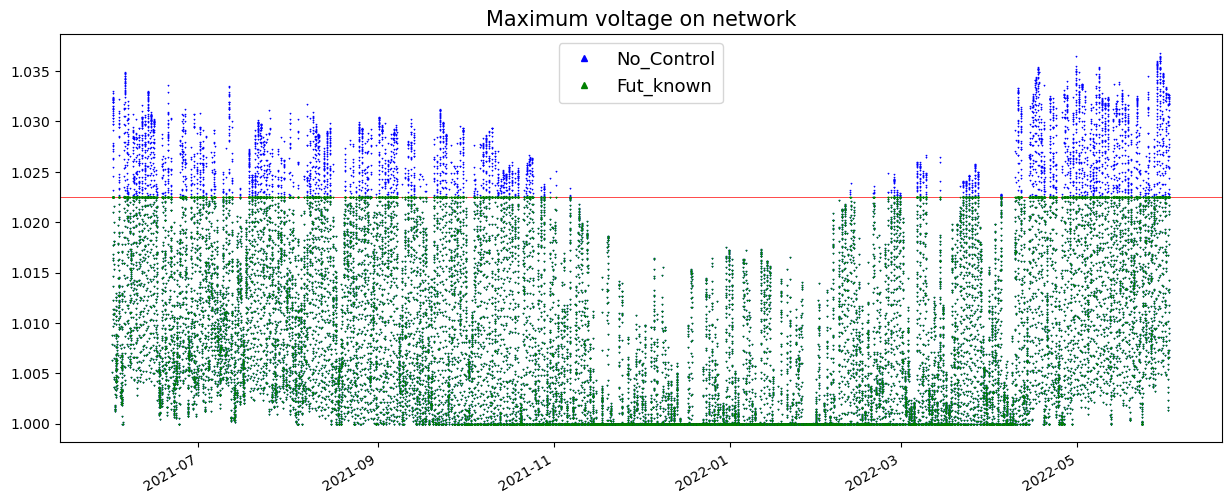

In [21]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max,color='r', lw=0.5)

voltage_rise_df.plot(style = ['b^','g^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

#### Setting up variables

In [22]:
P0100_df = df_prodHT[['P0100']]

P0100_futKnown_df = pd.DataFrame(data=extracted_results.P0100.values, 
                                 index=extracted_results.index, columns=['Fut_known'] )
# Concat
P0100_concat_df = pd.concat([P0100_df,P0100_futKnown_df], axis=1)

# Rename
P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);

<AxesSubplot:>

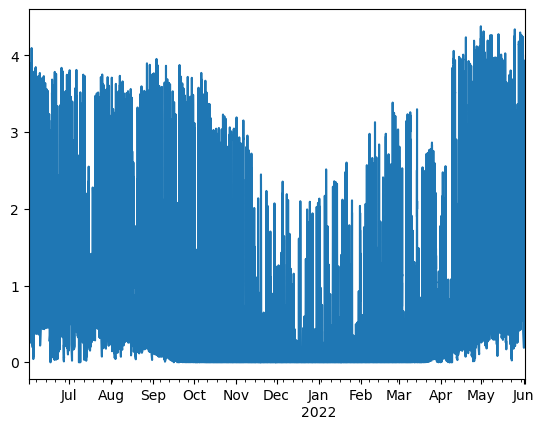

In [23]:
(P0100_concat_df.No_Control).plot()

<AxesSubplot:>

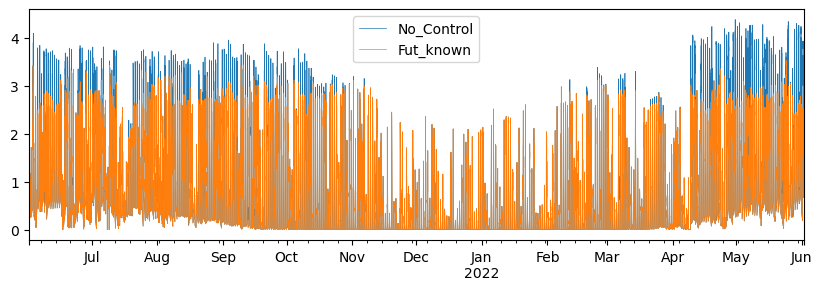

In [24]:
P0100_concat_df.plot(figsize=(10,3), lw=0.5)

In [25]:
# Compute Energy
var_no_control, var_futureknown = P0100_concat_df.sum()*Δt

print(f'P0100 prod,   No Control  : {var_no_control:.2f} MWh')
print(f'P0100 prod, Future known  : {var_futureknown:.2f} MWh |  Perc = {var_futureknown*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5229.63 MWh
P0100 prod, Future known  : 4572.38 MWh |  Perc = 87.43%


In [24]:
# Compute Energy
var_no_control, var_futureknown = P0100_concat_df.sum()*Δt

print(f'P0100 prod,   No Control  : {var_no_control:.2f} MWh')
print(f'P0100 prod, Future known  : {var_futureknown:.2f} MWh |  Perc = {var_futureknown*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5229.63 MWh
P0100 prod, Future known  : 4866.73 MWh |  Perc = 93.06%


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [26]:
var_to_save = dict({'P0100_concat_df':P0100_concat_df,
                    'voltage_rise_df':voltage_rise_df})

joblib.dump(var_to_save,'pickle_files/simulationResults/KnownFuture2.pkl')


['pickle_files/simulationResults/KnownFuture2.pkl']

<AxesSubplot:>

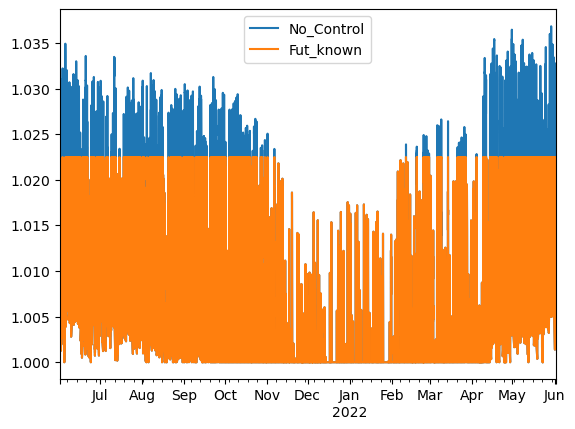

Controller stopped: {'exit_code': 15, 'pid': 24644, 'identifier': 'ipcontroller-1669888251-qav5-24888'}
Stopping engine(s): 1669888253
engine set stopped 1669888253: {'engines': {'1': {'exit_code': 15, 'pid': 28556, 'identifier': '1'}, '2': {'exit_code': 15, 'pid': 18872, 'identifier': '2'}, '5': {'exit_code': 15, 'pid': 13652, 'identifier': '5'}, '4': {'exit_code': 15, 'pid': 20948, 'identifier': '4'}, '0': {'exit_code': 15, 'pid': 17712, 'identifier': '0'}, '3': {'exit_code': 15, 'pid': 24600, 'identifier': '3'}, '6': {'exit_code': 15, 'pid': 3896, 'identifier': '6'}}, 'exit_code': 15}


Stopping cluster <Cluster(cluster_id='1669888251-qav5', profile='default', controller=<after>, engine_sets=['1669888253'])>


In [27]:
var_to_save.get('voltage_rise_df').plot()